<a href="https://colab.research.google.com/github/anuragbantu/DL-Assignment-1/blob/main/Assignment-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import fashion_mnist




**Question 1**

In [103]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


In [104]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [105]:
x_train.shape

(60000, 28, 28)

In [106]:
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

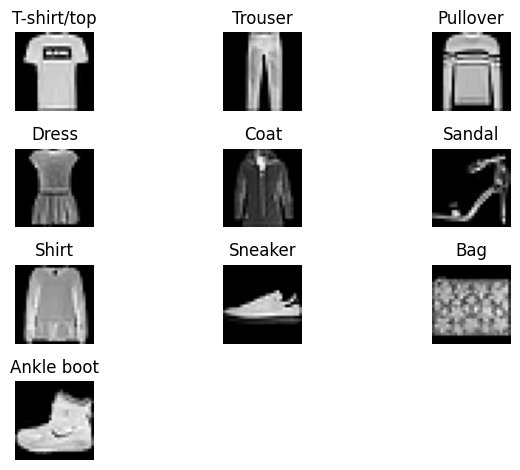

In [84]:
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    plt.subplot(4, 3, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(class_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Question 2**

preparing the dataset.

In [85]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.0



In [86]:
def one_hot_encode(labels, num_classes=None):
    if num_classes is None:
        num_classes = np.max(labels) + 1

    encoded = np.zeros((len(labels), num_classes))

    encoded[np.arange(len(labels)), labels] = 1

    return encoded

y_train = one_hot_encode(y_train)


In [87]:
y_test = one_hot_encode(y_test)

In [88]:
y_train.shape

(60000, 10)

In [89]:
x_train.shape

(60000, 28, 28, 1)

Define a class for layers.

In [90]:
def sigmoid(x):
  return 0.5 * (1 + np.tanh(0.5 * x))

def sigmoid_d(x):
  s= sigmoid(x)
  return s*(1-s)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True) + 1e-8)
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def softmax_d(x):
    diag_s = np.diag(x)

    outer_s = np.outer(x, x)
    return diag_s - outer_s

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    return 1 - np.square(np.tanh(x))

def relu(x):
    return np.maximum(0, x)

def relu_d(x):
    return np.where(x > 0, 1, 0)

#CCE loss function
def categorical_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred), axis=-1)
    return np.mean(loss)

activations = {"sigmoid":sigmoid,"softmax":softmax,"tanh":tanh,"relu":relu}

derivatives = {"sigmoid":sigmoid_d}





In [91]:
class layer:
  def __init__(self, input, neurons, activation, weight_init):
    if weight_init == "xavier":
        self.weights = np.random.randn(input, neurons) * np.sqrt(1 / input)
    else:
        self.weights = np.random.randn(input, neurons)
    self.bias = np.zeros((1, neurons))
    self.activation = activations[activation]
    self.activation_d = derivatives.get(activation, None)

  def forward(self, a_prev):
    self.a_prev = a_prev
    self.z = np.dot(self.a_prev,self.weights) + self.bias
    self.a = self.activation(self.z)
    return self.a

  def sgd(self,w_d,b_d,lr):
    self.weights -= lr*w_d
    self.bias -= lr*b_d

  def momentum_gd(self, w_d, b_d, lr, momentum=0.9):
    if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
    if not hasattr(self, 'm_b'):
        self.m_b = np.zeros_like(self.bias)
    self.m_w = momentum * self.m_w + lr * w_d
    self.m_b = momentum * self.m_b + lr * b_d
    self.weights -= self.m_w
    self.bias -= self.m_b

  def nesterov_gd(self, w_d, b_d, lr, momentum=0.9):
      if not hasattr(self, 'm_w'):
          self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      m_w_prev, m_b_prev = self.m_w, self.m_b
      self.m_w = momentum * self.m_w + lr * w_d
      self.m_b = momentum * self.m_b + lr * b_d
      self.weights -= momentum * m_w_prev + (1 + momentum) * self.m_w
      self.bias -= momentum * m_b_prev + (1 + momentum) * self.m_b

  def rmsprop(self, w_d, b_d, lr, decay_rate=0.9, epsilon=1e-8):
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      self.v_w = decay_rate * self.v_w + (1 - decay_rate) * np.square(w_d)
      self.v_b = decay_rate * self.v_b + (1 - decay_rate) * np.square(b_d)
      self.weights -= lr * w_d / (np.sqrt(self.v_w) + epsilon)
      self.bias -= lr * b_d / (np.sqrt(self.v_b) + epsilon)

  def adam(self, w_d, b_d, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):

      if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      if not hasattr(self, 't'):
          self.t = 0

      self.t += 1

      self.m_w = beta1 * self.m_w + (1 - beta1) * w_d
      self.m_b = beta1 * self.m_b + (1 - beta1) * b_d
      self.v_w = beta2 * self.v_w + (1 - beta2) * np.square(w_d)
      self.v_b = beta2 * self.v_b + (1 - beta2) * np.square(b_d)
      m_w_hat = self.m_w / (1 - beta1**self.t)
      m_b_hat = self.m_b / (1 - beta1**self.t)
      v_w_hat = self.v_w / (1 - beta2**self.t)
      v_b_hat = self.v_b / (1 - beta2**self.t)
      self.weights -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
      self.bias -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

  def nadam(self, w_d, b_d, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):
      if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      if not hasattr(self, 't'):
          self.t = 0
      self.t += 1
      self.m_w = beta1 * self.m_w + (1 - beta1) * w_d
      self.m_b = beta1 * self.m_b + (1 - beta1) * b_d
      self.v_w = beta2 * self.v_w + (1 - beta2) * np.square(w_d)
      self.v_b = beta2 * self.v_b + (1 - beta2) * np.square(b_d)
      m_w_hat = self.m_w / (1 - beta1**self.t)
      m_b_hat = self.m_b / (1 - beta1**self.t)
      v_w_hat = self.v_w / (1 - beta2**self.t)
      v_b_hat = self.v_b / (1 - beta2**self.t)
      m_w_bar = beta1 * m_w_hat + ((1 - beta1) / (1 - beta1**self.t)) * w_d
      m_b_bar = beta1 * m_b_hat + ((1 - beta1) / (1 - beta1**self.t)) * b_d
      self.weights -= lr * m_w_bar / (np.sqrt(v_w_hat) + epsilon)
      self.bias -= lr * m_b_bar / (np.sqrt(v_b_hat) + epsilon)

  def backprop(self, a_d, lr, optimizer):
    if self.activation_d:
      z_d = np.multiply(self.activation_d(self.z),a_d)
    else:
      z_d = a_d
    w_d = np.dot(self.a_prev.T,z_d)
    b_d = np.sum(z_d,axis=0,keepdims=True)
    a_prev_d = np.dot(z_d,self.weights.T)

    if optimizer == 'sgd':
            self.sgd(w_d, b_d, lr)
    elif optimizer == 'momentum':
        self.momentum_gd(w_d, b_d, lr)
    elif optimizer == 'nesterov':
        self.nesterov_gd(w_d, b_d, lr)
    elif optimizer == 'rmsprop':
        self.rmsprop(w_d, b_d, lr)
    elif optimizer == 'adam':
        self.adam(w_d, b_d, lr)
    elif optimizer == 'nadam':
        self.nadam(w_d, b_d, lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")

    return a_prev_d


#layers = [layer(784,128,"sigmoid"),layer(128,128,"sigmoid"),layer(128,10,"softmax")]

In [92]:
"""def train_network(layers, x_train, y_train, epochs, lr, optimizer='sgd'):
    for epoch in range(epochs):
        # Forward pass
        a = x_train
        for layer in layers:
            a = layer.forward(a)

        # Calculate and print the loss
        loss = categorical_cross_entropy(y_train, a)
        print(f"Epoch {epoch + 1}, Loss: {loss}")

        # Backward pass
        a_d = a - y_train
        for layer in reversed(layers):
            a_d = layer.backprop(a_d, lr, optimizer)


x_train = x_train.reshape(x_train.shape[0], -1)

train_network(layers, x_train, y_train, epochs=10, lr=0.01, optimizer='sgd')"""


'def train_network(layers, x_train, y_train, epochs, lr, optimizer=\'sgd\'):\n    for epoch in range(epochs):\n        # Forward pass\n        a = x_train\n        for layer in layers:\n            a = layer.forward(a)\n\n        # Calculate and print the loss\n        loss = categorical_cross_entropy(y_train, a)\n        print(f"Epoch {epoch + 1}, Loss: {loss}")\n\n        # Backward pass\n        a_d = a - y_train\n        for layer in reversed(layers):\n            a_d = layer.backprop(a_d, lr, optimizer)\n\n\nx_train = x_train.reshape(x_train.shape[0], -1)\n\ntrain_network(layers, x_train, y_train, epochs=10, lr=0.01, optimizer=\'sgd\')'

# Question 3

Implement backpropagation algorithm

# Question 4


In [93]:
!pip install wandb -Uq

Epoch 5, Loss: 0.7847493077962938, Accuracy: 0.7007222222222222, val_loss: 0.8187141455720636, val_accuracy: 0.7073333333333334


Traceback (most recent call last):
  File "<ipython-input-78-15d74bf9236b>", line 57, in train_network
    wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc,
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/lib/preinit.py", line 36, in preinit_wrapper
    raise wandb.Error(f"You must call wandb.init() before {name}()")
wandb.errors.errors.Error: You must call wandb.init() before wandb.log()


In [94]:
import wandb
wandb.login()

True

In [95]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },

    'lr': {
          'values': [0.001, 0.01, 0.1]
        },
    }

sweep_config['parameters'] = parameters_dict

In [96]:
sweep_id = wandb.sweep(sweep_config, project="dla1-sweeps")

Create sweep with ID: 4jsc140f
Sweep URL: https://wandb.ai/ma24m003-iit-madras/dla1-sweeps/sweeps/4jsc140f


In [97]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

In [98]:
x_train.shape

(54000, 28, 28, 1)

In [99]:
x_val.shape

(6000, 28, 28, 1)

In [100]:
import wandb
import numpy as np

sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'fc_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'lr': {'values': [1e-3, 1e-4]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="neural-network-hyperparam-tuning")

def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))



"""
def train_network(config=None):
    with wandb.init(config=config, project="neural-network-hyperparam-tuning"):
        config = wandb.config
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
        wandb.run.name = run_name

        layers = [
            layer(784, config.fc_layer_size, config.activation, config.weight_init)
        ]

        for _ in range(config.num_hidden_layers - 1):
            layers.append(layer(config.fc_layer_size, config.fc_layer_size, config.activation, config.weight_init))
        layers.append(layer(config.fc_layer_size, 10, "softmax", config.weight_init))

        for epoch in range(config.epochs):
            a_val = x_val
            for l in layers:
                a_val = l.forward(a_val)



            a = x_train
            for l in layers:
                a = l.forward(a)

            loss = categorical_cross_entropy(y_train, a)
            acc = accuracy(y_train, a)


            # Compute test loss & accuracy
            val_loss = categorical_cross_entropy(y_val, a_val)
            val_acc = accuracy(y_val, a_val)


            print(f"Epoch {epoch + 1}, Loss: {loss}, Accuracy: {acc}, val_loss: {val_loss}, val_accuracy: {val_acc}")

            wandb.log({"epoch": epoch + 1, "loss": loss, "accuracy": acc,
               "val_loss": val_loss, "val_accuracy": val_acc})

            a_d = a - y_train
            for l in reversed(layers):
                a_d = l.backprop(a_d, config.lr, config.optimizer)




x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)



wandb.agent(sweep_id, train_network, count=10)

wandb.finish()"""



Create sweep with ID: 3t3ru3kf
Sweep URL: https://wandb.ai/ma24m003-iit-madras/neural-network-hyperparam-tuning/sweeps/3t3ru3kf


'\ndef train_network(config=None):\n    with wandb.init(config=config, project="neural-network-hyperparam-tuning"):\n        config = wandb.config\n        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"\n        wandb.run.name = run_name\n\n        layers = [\n            layer(784, config.fc_layer_size, config.activation, config.weight_init)\n        ]\n\n        for _ in range(config.num_hidden_layers - 1):\n            layers.append(layer(config.fc_layer_size, config.fc_layer_size, config.activation, config.weight_init))\n        layers.append(layer(config.fc_layer_size, 10, "softmax", config.weight_init))\n\n        for epoch in range(config.epochs):\n            a_val = x_val\n            for l in layers:\n                a_val = l.forward(a_val)\n\n\n\n            a = x_train\n            for l in layers:\n                a = l.forward(a)\n\n            loss = categorical_cross_entropy(y_train, a)\n            acc = accuracy(y_train, a)\

In [107]:
def train_network(config=None):
    with wandb.init(config=config, project="neural-network-hyperparam-tuning"):
        config = wandb.config
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
        wandb.run.name = run_name

        layers = [
            layer(784, config.fc_layer_size, config.activation, config.weight_init)
        ]

        for _ in range(config.num_hidden_layers - 1):
            layers.append(layer(config.fc_layer_size, config.fc_layer_size, config.activation, config.weight_init))
        layers.append(layer(config.fc_layer_size, 10, "softmax", config.weight_init))

        num_samples = x_train.shape[0]

        for epoch in range(config.epochs):
            shuffled_indices = np.random.permutation(num_samples)
            x_train_shuffled = x_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]

            epoch_loss = 0
            epoch_acc = 0

            for start in range(0, num_samples, config.batch_size):
                end = min(start + config.batch_size, num_samples)
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]

                a = x_batch
                for l in layers:
                    a = l.forward(a)

                loss = categorical_cross_entropy(y_batch, a)
                acc = accuracy(y_batch, a)

                epoch_loss += loss
                epoch_acc += acc

                a_d = a - y_batch
                for l in reversed(layers):
                    a_d = l.backprop(a_d, config.lr, config.optimizer)

            num_batches = max(1, num_samples // config.batch_size)
            avg_loss = epoch_loss / num_batches
            avg_acc = epoch_acc / num_batches

            a_val = x_val
            for l in layers:
                a_val = l.forward(a_val)

            val_loss = categorical_cross_entropy(y_val, a_val)
            val_acc = accuracy(y_val, a_val)

            print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}, val_loss: {val_loss}, val_accuracy: {val_acc}")

            wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc,
                       "val_loss": val_loss, "val_accuracy": val_acc})

x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)

wandb.agent(sweep_id, train_network, count=50)

wandb.finish()


wandb: Agent Starting Run: orp5jci5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.3329703334430723, Accuracy: 0.5298236514522822, val_loss: 1.1596199181137745, val_accuracy: 0.5298333333333334
Epoch 2, Loss: 1.1305389208079069, Accuracy: 0.5336395969176052, val_loss: 1.1228903974905184, val_accuracy: 0.5266666666666666
Epoch 3, Loss: 1.1183401494996015, Accuracy: 0.5301756075874333, val_loss: 1.1328653523050054, val_accuracy: 0.5555
Epoch 4, Loss: 1.1319773548614827, Accuracy: 0.5451800533491404, val_loss: 1.143021452203994, val_accuracy: 0.5581666666666667
Epoch 5, Loss: 1.1350422658801742, Accuracy: 0.5640930646117368, val_loss: 1.1216770869282098, val_accuracy: 0.5741666666666667
Epoch 6, Loss: 1.1060731694619628, Accuracy: 0.5717249555423829, val_loss: 1.0876871827709356, val_accuracy: 0.5815
Epoch 7, Loss: 1.0643844873154484, Accuracy: 0.5976029934795495, val_loss: 1.0317449415791877, val_accuracy: 0.6243333333333333
Epoch 8, Loss: 1.017288671140003, Accuracy: 0.6237218435091879, val_loss: 1.0026933714350075, val_accuracy: 0.6328333333333334
Ep

accuracy,▁▁▁▂▄▄▆██▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▄▄▃▂▁▁▁
val_accuracy,▁▁▃▃▄▅▇█▇▆
val_loss,█▆▇▇▆▅▂▁▁▁
accuracy,0.60655
epoch,10
loss,1.01538
val_accuracy,0.60117
val_loss,1.00998


wandb: Agent Starting Run: apn78ofw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 2.3073469486858813, Accuracy: 0.09977387307236062, val_loss: 2.3028671166507713, val_accuracy: 0.0995
Epoch 2, Loss: 2.305549343659005, Accuracy: 0.1000580763147489, val_loss: 2.302603334569126, val_accuracy: 0.10533333333333333
Epoch 3, Loss: 2.3053594684405176, Accuracy: 0.10121960260972716, val_loss: 2.3022289718090634, val_accuracy: 0.12983333333333333
Epoch 4, Loss: 2.305248642269562, Accuracy: 0.10323991696322657, val_loss: 2.3023740208492454, val_accuracy: 0.0995
Epoch 5, Loss: 2.305090709058177, Accuracy: 0.10425316330565441, val_loss: 2.3020538949147302, val_accuracy: 0.1055


accuracy,▁▁▃▆█
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_accuracy,▁▂█▁▂
val_loss,█▆▃▄▁
accuracy,0.10425
epoch,5
loss,2.30509
val_accuracy,0.1055
val_loss,2.30205


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6shtnj8j with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 28.658232289472743, Accuracy: 0.15137818612922346, val_loss: 25.47104706934922, val_accuracy: 0.23483333333333334
Epoch 2, Loss: 20.70967827622529, Accuracy: 0.3681275933609959, val_loss: 17.908603771501216, val_accuracy: 0.44783333333333336
Epoch 3, Loss: 16.425825458214103, Accuracy: 0.4908491404860699, val_loss: 15.399133683954632, val_accuracy: 0.524
Epoch 4, Loss: 14.530390144251065, Accuracy: 0.5468472139893301, val_loss: 14.023836501002632, val_accuracy: 0.5636666666666666
Epoch 5, Loss: 13.433680218238182, Accuracy: 0.578504742145821, val_loss: 13.023187805597253, val_accuracy: 0.5896666666666667
Epoch 6, Loss: 12.666891690173479, Accuracy: 0.6014189389448725, val_loss: 12.475023634798115, val_accuracy: 0.6098333333333333
Epoch 7, Loss: 12.171808706533296, Accuracy: 0.6146450800237108, val_loss: 11.973549824049886, val_accuracy: 0.62
Epoch 8, Loss: 11.706489153473868, Accuracy: 0.6281490812092472, val_loss: 11.530035220600674, val_accuracy: 0.6346666666666667
Epo

accuracy,▁▄▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▃▂▂▂▁▁▁
accuracy,0.6498
epoch,10
loss,10.87792
val_accuracy,0.647
val_loss,10.89529


wandb: Agent Starting Run: zvo9i67r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.5259002761597151, Accuracy: 0.48041468960063266, val_loss: 1.3225553596776958, val_accuracy: 0.5495
Epoch 2, Loss: 1.2552870343359046, Accuracy: 0.5337089758797944, val_loss: 1.1992204379178437, val_accuracy: 0.5405
Epoch 3, Loss: 1.1661169951448926, Accuracy: 0.5362050217477263, val_loss: 1.141969397798274, val_accuracy: 0.538
Epoch 4, Loss: 1.1208205365576875, Accuracy: 0.561369365361803, val_loss: 1.1090124013461107, val_accuracy: 0.5916666666666667
Epoch 5, Loss: 1.088688234705515, Accuracy: 0.5944110814551207, val_loss: 1.0794784637949189, val_accuracy: 0.5971666666666666
Epoch 6, Loss: 1.0631153588816433, Accuracy: 0.5938921016211942, val_loss: 1.055477586519537, val_accuracy: 0.5858333333333333
Epoch 7, Loss: 1.0460980461375209, Accuracy: 0.5858293792012653, val_loss: 1.041078248492723, val_accuracy: 0.5806666666666667
Epoch 8, Loss: 1.0360445282752855, Accuracy: 0.5749246243574535, val_loss: 1.028953341430452, val_accuracy: 0.5718333333333333
Epoch 9, Loss: 1.0

accuracy,▁▄▄▆██▇▇▆▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▂▁▁▇█▇▆▅▄▄
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.56075
epoch,10
loss,1.02241
val_accuracy,0.565
val_loss,1.01439


wandb: Agent Starting Run: 2neeo3ar with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.9934195821689226, Accuracy: 0.6343148148148148, val_loss: 0.6833159880940708, val_accuracy: 0.7303333333333333
Epoch 2, Loss: 0.6171286318279348, Accuracy: 0.7677037037037037, val_loss: 0.5733166613293549, val_accuracy: 0.7898333333333334
Epoch 3, Loss: 0.5479145966098786, Accuracy: 0.8036481481481481, val_loss: 0.5268103137296953, val_accuracy: 0.814
Epoch 4, Loss: 0.5090823227602185, Accuracy: 0.8201481481481482, val_loss: 0.4917574983944382, val_accuracy: 0.8266666666666667
Epoch 5, Loss: 0.48229082167643356, Accuracy: 0.8303888888888888, val_loss: 0.47912690711355027, val_accuracy: 0.831
Epoch 6, Loss: 0.4638981515964764, Accuracy: 0.8365185185185186, val_loss: 0.4592483748949228, val_accuracy: 0.8405
Epoch 7, Loss: 0.4513739558370364, Accuracy: 0.8411481481481482, val_loss: 0.4483043997160221, val_accuracy: 0.8466666666666667
Epoch 8, Loss: 0.44089721917925284, Accuracy: 0.8433703703703703, val_loss: 0.4426980383944106, val_accuracy: 0.8476666666666667
Epoch 9, Lo

accuracy,▁▅▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.84909
epoch,10
loss,0.42529
val_accuracy,0.85067
val_loss,0.42993


wandb: Agent Starting Run: 7we7ujqg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.651071190119013, Accuracy: 0.7688944872554832, val_loss: 0.4946299674779666, val_accuracy: 0.8271666666666667
Epoch 2, Loss: 0.4681817376918782, Accuracy: 0.8367849733254298, val_loss: 0.4450512284716276, val_accuracy: 0.844
Epoch 3, Loss: 0.4431855010302158, Accuracy: 0.8427867516301126, val_loss: 0.43938785765526955, val_accuracy: 0.8413333333333334
Epoch 4, Loss: 0.43144060272615053, Accuracy: 0.8469546532305868, val_loss: 0.4313999132201956, val_accuracy: 0.8498333333333333
Epoch 5, Loss: 0.42260881749905355, Accuracy: 0.8504186425607587, val_loss: 0.42171604340743823, val_accuracy: 0.8515
Epoch 6, Loss: 0.4140144831754528, Accuracy: 0.853919679905157, val_loss: 0.422004330497348, val_accuracy: 0.8573333333333333
Epoch 7, Loss: 0.4119574129579822, Accuracy: 0.854419828097214, val_loss: 0.4228292491620197, val_accuracy: 0.851
Epoch 8, Loss: 0.4111771849514196, Accuracy: 0.8541234439834025, val_loss: 0.42011369239174223, val_accuracy: 0.852
Epoch 9, Loss: 0.412437540

accuracy,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▅▄▆▇█▇▇▆▆
val_loss,█▃▃▂▁▁▁▁▁▂
accuracy,0.85449
epoch,10
loss,0.41223
val_accuracy,0.84783
val_loss,0.43208


wandb: Agent Starting Run: nx3xcabn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.7677474661712753, Accuracy: 0.7154259259259259, val_loss: 0.7107241960447894, val_accuracy: 0.7415
Epoch 2, Loss: 0.6623566463020508, Accuracy: 0.7629814814814815, val_loss: 0.6428169570692929, val_accuracy: 0.7751666666666667
Epoch 3, Loss: 0.6407620915132687, Accuracy: 0.7746481481481482, val_loss: 0.6443735293217395, val_accuracy: 0.7758333333333334
Epoch 4, Loss: 0.6388813528520564, Accuracy: 0.7679074074074074, val_loss: 0.6703990751682258, val_accuracy: 0.7541666666666667
Epoch 5, Loss: 0.6924102896475067, Accuracy: 0.7474074074074074, val_loss: 0.7058255823830356, val_accuracy: 0.7341666666666666
Epoch 6, Loss: 0.7664092436985841, Accuracy: 0.7175370370370371, val_loss: 0.820642402332348, val_accuracy: 0.6788333333333333
Epoch 7, Loss: 0.8148164492282982, Accuracy: 0.6892962962962963, val_loss: 0.7817660521628625, val_accuracy: 0.7195
Epoch 8, Loss: 0.7634486530607753, Accuracy: 0.7207222222222223, val_loss: 0.7688815414475142, val_accuracy: 0.7175
Epoch 9, Loss

accuracy,▃▇█▇▆▃▁▄▄▄
epoch,▁▂▃▃▄▅▆▆▇█
loss,▆▂▁▁▃▆█▆▅▆
val_accuracy,▆██▆▅▁▄▄▄▃
val_loss,▄▁▁▂▃█▆▆▅▆
accuracy,0.72011
epoch,10
loss,0.75432
val_accuracy,0.70067
val_loss,0.76341


wandb: Agent Starting Run: 2cqffi9y with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.6816980355078247, Accuracy: 0.751537037037037, val_loss: 0.5192051263347959, val_accuracy: 0.8141666666666667
Epoch 2, Loss: 0.5116475430551889, Accuracy: 0.8180925925925926, val_loss: 0.49287129492486836, val_accuracy: 0.8273333333333334
Epoch 3, Loss: 0.47644359711919176, Accuracy: 0.8291851851851851, val_loss: 0.4651162208937983, val_accuracy: 0.8356666666666667
Epoch 4, Loss: 0.4784970863489692, Accuracy: 0.8280555555555555, val_loss: 0.5179831887487936, val_accuracy: 0.8208333333333333
Epoch 5, Loss: 0.4780297902470479, Accuracy: 0.8278148148148148, val_loss: 0.5419834920898237, val_accuracy: 0.81
Epoch 6, Loss: 0.4710926824744299, Accuracy: 0.8343148148148148, val_loss: 0.4807523731290762, val_accuracy: 0.8366666666666667
Epoch 7, Loss: 0.4713402688502463, Accuracy: 0.8336666666666667, val_loss: 0.481279273276939, val_accuracy: 0.8385
Epoch 8, Loss: 0.4788404779791508, Accuracy: 0.8297037037037037, val_loss: 0.5434210285145598, val_accuracy: 0.8071666666666667
Ep

accuracy,▁▇█▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▂
val_accuracy,▃▆▇▄▂██▁▆▅
val_loss,▆▃▁▆█▂▂█▆▆
accuracy,0.83389
epoch,10
loss,0.49116
val_accuracy,0.826
val_loss,0.51919


wandb: Agent Starting Run: a649x0dc with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.612761399519995, Accuracy: 0.7772407407407408, val_loss: 0.47888278842062204, val_accuracy: 0.8306666666666667
Epoch 2, Loss: 0.4619989065828893, Accuracy: 0.835037037037037, val_loss: 0.4501375203816876, val_accuracy: 0.846
Epoch 3, Loss: 0.44164640415531464, Accuracy: 0.8404444444444444, val_loss: 0.4688609279680837, val_accuracy: 0.834
Epoch 4, Loss: 0.42929876813418855, Accuracy: 0.846574074074074, val_loss: 0.438730739527422, val_accuracy: 0.8458333333333333
Epoch 5, Loss: 0.4226506795534145, Accuracy: 0.8493333333333334, val_loss: 0.47244165781966474, val_accuracy: 0.835


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_accuracy,▁█▃█▃
val_loss,█▃▆▁▇
accuracy,0.84933
epoch,5
loss,0.42265
val_accuracy,0.835
val_loss,0.47244


wandb: Agent Starting Run: d26ufqfo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.6706263068256086, Accuracy: 0.7542037037037037, val_loss: 0.5461006814144715, val_accuracy: 0.8083333333333333
Epoch 2, Loss: 0.5057546403342958, Accuracy: 0.8228888888888889, val_loss: 0.47122225746489654, val_accuracy: 0.8378333333333333
Epoch 3, Loss: 0.4899261485402762, Accuracy: 0.8292777777777778, val_loss: 0.49513723064901616, val_accuracy: 0.8333333333333334
Epoch 4, Loss: 0.486937535727625, Accuracy: 0.8317222222222223, val_loss: 0.4826909142593103, val_accuracy: 0.8333333333333334
Epoch 5, Loss: 0.46340685223272965, Accuracy: 0.8392407407407407, val_loss: 0.4621777750186357, val_accuracy: 0.837


accuracy,▁▇▇▇█
epoch,▁▃▅▆█
loss,█▂▂▂▁
val_accuracy,▁█▇▇█
val_loss,█▂▄▃▁
accuracy,0.83924
epoch,5
loss,0.46341
val_accuracy,0.837
val_loss,0.46218


wandb: Agent Starting Run: 68tljpo4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 13.373013729799153, Accuracy: 0.5608333333333333, val_loss: 9.863365276323258, val_accuracy: 0.6563333333333333
Epoch 2, Loss: 8.452765283460531, Accuracy: 0.6852777777777778, val_loss: 7.773911950481591, val_accuracy: 0.7011666666666667
Epoch 3, Loss: 7.349194251955975, Accuracy: 0.7071851851851851, val_loss: 6.909624012945768, val_accuracy: 0.7063333333333334
Epoch 4, Loss: 6.557801303182999, Accuracy: 0.7185, val_loss: 5.999459266411546, val_accuracy: 0.7318333333333333
Epoch 5, Loss: 5.842616464801076, Accuracy: 0.7334074074074074, val_loss: 5.267871164884157, val_accuracy: 0.7505
Epoch 6, Loss: 5.476215099773919, Accuracy: 0.7423703703703703, val_loss: 5.174907417866127, val_accuracy: 0.7515
Epoch 7, Loss: 5.129370102464207, Accuracy: 0.75, val_loss: 4.997914358818392, val_accuracy: 0.7505
Epoch 8, Loss: 4.634359329495989, Accuracy: 0.7553888888888889, val_loss: 4.67192477980768, val_accuracy: 0.7543333333333333
Epoch 9, Loss: 4.312952786341169, Accuracy: 0.75883333

accuracy,▁▅▆▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▃▂▂▂▂▁▁
val_accuracy,▁▄▅▆████▇▆
val_loss,█▅▄▃▂▂▂▂▂▁
accuracy,0.76413
epoch,10
loss,3.83962
val_accuracy,0.73117
val_loss,4.03001


wandb: Agent Starting Run: pemfv2yv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.8295338791029283, Accuracy: 0.6953217674970344, val_loss: 0.5499960132657727, val_accuracy: 0.8085
Epoch 2, Loss: 0.5146332505605189, Accuracy: 0.8193208778173191, val_loss: 0.4859777872999366, val_accuracy: 0.8278333333333333
Epoch 3, Loss: 0.4691755728073812, Accuracy: 0.8332283017002768, val_loss: 0.4493309683173912, val_accuracy: 0.8401666666666666
Epoch 4, Loss: 0.44626658655858353, Accuracy: 0.8417173289837881, val_loss: 0.43534586175926726, val_accuracy: 0.8421666666666666
Epoch 5, Loss: 0.43415332522858474, Accuracy: 0.845665282720443, val_loss: 0.4450536425806031, val_accuracy: 0.8441666666666666
Epoch 6, Loss: 0.42599791803224074, Accuracy: 0.8484949584816133, val_loss: 0.44079480488514067, val_accuracy: 0.8431666666666666
Epoch 7, Loss: 0.41926156351237354, Accuracy: 0.8499159746935547, val_loss: 0.44219407122269816, val_accuracy: 0.8446666666666667
Epoch 8, Loss: 0.4136075038391981, Accuracy: 0.8521339956504548, val_loss: 0.41873410835829067, val_accuracy: 

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▆▆▆███
val_loss,█▅▃▂▃▃▃▁▁▁
accuracy,0.85688
epoch,10
loss,0.40239
val_accuracy,0.85533
val_loss,0.40884


wandb: Agent Starting Run: jiymty0f with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5707208715660286, Accuracy: 0.794425925925926, val_loss: 0.5068440987115969, val_accuracy: 0.8186666666666667
Epoch 2, Loss: 0.4705659930403764, Accuracy: 0.8327407407407408, val_loss: 0.47840227700005805, val_accuracy: 0.8315
Epoch 3, Loss: 0.44220089145853647, Accuracy: 0.8439444444444445, val_loss: 0.4094615515127177, val_accuracy: 0.8533333333333334
Epoch 4, Loss: 0.43274377427428695, Accuracy: 0.8478703703703704, val_loss: 0.423199068888257, val_accuracy: 0.85
Epoch 5, Loss: 0.42444036709877514, Accuracy: 0.8517592592592592, val_loss: 0.43007133412441595, val_accuracy: 0.8521666666666666


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▄█▇█
val_loss,█▆▁▂▂
accuracy,0.85176
epoch,5
loss,0.42444
val_accuracy,0.85217
val_loss,0.43007


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p885g723 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5908392705969409, Accuracy: 0.7836410142348754, val_loss: 0.5120122008530644, val_accuracy: 0.8051666666666667
Epoch 2, Loss: 0.4520374494106281, Accuracy: 0.8383254250691974, val_loss: 0.4808711059251495, val_accuracy: 0.8308333333333333
Epoch 3, Loss: 0.4302251785164384, Accuracy: 0.845943307631475, val_loss: 0.47176076886581775, val_accuracy: 0.8255
Epoch 4, Loss: 0.4155720155467217, Accuracy: 0.8515470541716093, val_loss: 0.403073904068762, val_accuracy: 0.856
Epoch 5, Loss: 0.4073673596679731, Accuracy: 0.8538330367734283, val_loss: 0.41312638975233185, val_accuracy: 0.8548333333333333
Epoch 6, Loss: 0.39964878558076433, Accuracy: 0.8571384440490313, val_loss: 0.4291540467192433, val_accuracy: 0.8545
Epoch 7, Loss: 0.39534154068661653, Accuracy: 0.8579786971134835, val_loss: 0.45252325132828264, val_accuracy: 0.8388333333333333
Epoch 8, Loss: 0.3897556974346828, Accuracy: 0.8610060794780545, val_loss: 0.39962386572050795, val_accuracy: 0.8603333333333333
Epoch 9, 

accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▂▂▁▁▁
val_accuracy,▁▄▄▇▇▇▅█▇█
val_loss,█▆▆▂▂▃▅▂▃▁
accuracy,0.86269
epoch,10
loss,0.37968
val_accuracy,0.86117
val_loss,0.38705


wandb: Agent Starting Run: glue9mlb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5834093541328902, Accuracy: 0.7882129794385132, val_loss: 0.4332862697514548, val_accuracy: 0.8533333333333334
Epoch 2, Loss: 0.44222731472365423, Accuracy: 0.8424340154211151, val_loss: 0.42643486711465267, val_accuracy: 0.8483333333333334
Epoch 3, Loss: 0.42339906376287184, Accuracy: 0.8494464215104784, val_loss: 0.4019778830046896, val_accuracy: 0.8538333333333333
Epoch 4, Loss: 0.4128204899453786, Accuracy: 0.8518127224199288, val_loss: 0.413439771347229, val_accuracy: 0.8556666666666667
Epoch 5, Loss: 0.4046908583987813, Accuracy: 0.8568233491498617, val_loss: 0.4061484016098325, val_accuracy: 0.8543333333333333
Epoch 6, Loss: 0.401748877331617, Accuracy: 0.8564464709371293, val_loss: 0.41786265463662986, val_accuracy: 0.8496666666666667
Epoch 7, Loss: 0.3957423295458092, Accuracy: 0.8602337880585212, val_loss: 0.3931519334422698, val_accuracy: 0.8595
Epoch 8, Loss: 0.3920930709465233, Accuracy: 0.8606539145907474, val_loss: 0.39996107839580686, val_accuracy: 0.85

accuracy,▁▆▇▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▄▁▄▆▅▂█▆█▂
val_loss,█▇▃▅▄▅▁▂▁▇
accuracy,0.864
epoch,10
loss,0.38371
val_accuracy,0.85017
val_loss,0.42846


wandb: Agent Starting Run: 2d0ul8sp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5788149723019179, Accuracy: 0.7904074074074074, val_loss: 0.4526449181675686, val_accuracy: 0.8435
Epoch 2, Loss: 0.47279408358290836, Accuracy: 0.8316296296296296, val_loss: 0.4621396385575599, val_accuracy: 0.8391666666666666
Epoch 3, Loss: 0.44855426676913657, Accuracy: 0.8393703703703703, val_loss: 0.4328312602270025, val_accuracy: 0.841
Epoch 4, Loss: 0.4387548671038722, Accuracy: 0.8448703703703704, val_loss: 0.4447078033955703, val_accuracy: 0.8425
Epoch 5, Loss: 0.4346464813948311, Accuracy: 0.847037037037037, val_loss: 0.5208308595072642, val_accuracy: 0.8241666666666667
Epoch 6, Loss: 0.43504649462637396, Accuracy: 0.8456111111111111, val_loss: 0.4694854407239118, val_accuracy: 0.8418333333333333
Epoch 7, Loss: 0.4510516715754788, Accuracy: 0.8437222222222223, val_loss: 0.47369175547471287, val_accuracy: 0.8405
Epoch 8, Loss: 0.45819645327666997, Accuracy: 0.8455370370370371, val_loss: 0.5385479474106883, val_accuracy: 0.825
Epoch 9, Loss: 0.49531943164995845

accuracy,▁▆▇█████▇▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,▆▂▁▁▁▁▂▂▃█
val_accuracy,█▆▇█▁▇▇▁▃▆
val_loss,▂▂▁▁▃▂▂▄▄█
accuracy,0.82794
epoch,10
loss,0.63384
val_accuracy,0.83883
val_loss,0.69204


wandb: Agent Starting Run: vkppaii0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.6454224889461054, Accuracy: 0.7665555555555555, val_loss: 0.5065101029860855, val_accuracy: 0.8193333333333334
Epoch 2, Loss: 0.49324002546209017, Accuracy: 0.8256481481481481, val_loss: 0.4776254305226204, val_accuracy: 0.8333333333333334
Epoch 3, Loss: 0.4716440961796462, Accuracy: 0.8360555555555556, val_loss: 0.4583112440045787, val_accuracy: 0.8413333333333334
Epoch 4, Loss: 0.4602791780957864, Accuracy: 0.8403333333333334, val_loss: 0.4792695230164148, val_accuracy: 0.837
Epoch 5, Loss: 0.45413906888922595, Accuracy: 0.8409629629629629, val_loss: 0.4390985284279523, val_accuracy: 0.845


accuracy,▁▇███
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_accuracy,▁▅▇▆█
val_loss,█▅▃▅▁
accuracy,0.84096
epoch,5
loss,0.45414
val_accuracy,0.845
val_loss,0.4391


wandb: Agent Starting Run: wwat8cl7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5821724168982718, Accuracy: 0.7876666666666666, val_loss: 0.5081276453762094, val_accuracy: 0.8128333333333333
Epoch 2, Loss: 0.4705797510868421, Accuracy: 0.8329074074074074, val_loss: 0.5043371089699555, val_accuracy: 0.8213333333333334
Epoch 3, Loss: 0.4453571009253807, Accuracy: 0.841037037037037, val_loss: 0.4917025604965356, val_accuracy: 0.831
Epoch 4, Loss: 0.43917980773652304, Accuracy: 0.8453518518518518, val_loss: 0.4505456052331456, val_accuracy: 0.8506666666666667
Epoch 5, Loss: 0.4293394356632817, Accuracy: 0.8509814814814814, val_loss: 0.42495675521908016, val_accuracy: 0.853


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▂▄██
val_loss,██▇▃▁
accuracy,0.85098
epoch,5
loss,0.42934
val_accuracy,0.853
val_loss,0.42496


wandb: Agent Starting Run: 217fithz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5737050832215526, Accuracy: 0.7907777777777778, val_loss: 0.46008558745331873, val_accuracy: 0.8285
Epoch 2, Loss: 0.4543796148817725, Accuracy: 0.8378518518518518, val_loss: 0.4505897868469933, val_accuracy: 0.8421666666666666
Epoch 3, Loss: 0.4319233199572125, Accuracy: 0.8455925925925926, val_loss: 0.4342231375887959, val_accuracy: 0.8466666666666667
Epoch 4, Loss: 0.42394293618252626, Accuracy: 0.8473888888888889, val_loss: 0.4303484383184591, val_accuracy: 0.849
Epoch 5, Loss: 0.419335521187111, Accuracy: 0.8494074074074074, val_loss: 0.41743466076467584, val_accuracy: 0.8546666666666667


accuracy,▁▇███
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▅▆▆█
val_loss,█▆▄▃▁
accuracy,0.84941
epoch,5
loss,0.41934
val_accuracy,0.85467
val_loss,0.41743


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z8ly0zda with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.6304073585161919, Accuracy: 0.7688748022933967, val_loss: 0.5538432495765944, val_accuracy: 0.7985
Epoch 2, Loss: 0.4854521016534425, Accuracy: 0.8292494563068405, val_loss: 0.5735189598710065, val_accuracy: 0.7933333333333333
Epoch 3, Loss: 0.4600306309741207, Accuracy: 0.8373183570581257, val_loss: 0.4514482214754862, val_accuracy: 0.8368333333333333
Epoch 4, Loss: 0.44065228725333777, Accuracy: 0.8438612099644128, val_loss: 0.43519659182376125, val_accuracy: 0.8473333333333334
Epoch 5, Loss: 0.4197189111737746, Accuracy: 0.8500457196520363, val_loss: 0.45630360503176265, val_accuracy: 0.833


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▃▂▂▁
val_accuracy,▂▁▇█▆
val_loss,▇█▂▁▂
accuracy,0.85005
epoch,5
loss,0.41972
val_accuracy,0.833
val_loss,0.4563


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xq84kvaw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 13.423425087582148, Accuracy: 0.612149070778964, val_loss: 9.776497407808554, val_accuracy: 0.7166666666666667
Epoch 2, Loss: 9.05348230843768, Accuracy: 0.7386071569790431, val_loss: 9.032064541197858, val_accuracy: 0.7376666666666667
Epoch 3, Loss: 8.32155768486312, Accuracy: 0.7594590253064453, val_loss: 8.18966841322106, val_accuracy: 0.7621666666666667
Epoch 4, Loss: 7.9093835972162045, Accuracy: 0.7715253064452353, val_loss: 8.243611940829467, val_accuracy: 0.7603333333333333
Epoch 5, Loss: 7.659844685770246, Accuracy: 0.7787477758007118, val_loss: 7.936741380061821, val_accuracy: 0.7696666666666667


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▄▇▇█
val_loss,█▅▂▂▁
accuracy,0.77875
epoch,5
loss,7.65984
val_accuracy,0.76967
val_loss,7.93674


wandb: Agent Starting Run: lf2shegb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 14.32145235807172, Accuracy: 0.5864966389877422, val_loss: 10.40925135272742, val_accuracy: 0.6985
Epoch 2, Loss: 9.34551705848401, Accuracy: 0.7305258995650455, val_loss: 8.98583838540232, val_accuracy: 0.7398333333333333
Epoch 3, Loss: 8.637490409157174, Accuracy: 0.7510132463424278, val_loss: 8.490294803696406, val_accuracy: 0.7541666666666667
Epoch 4, Loss: 8.203974474050424, Accuracy: 0.7635985073151442, val_loss: 8.613993878826957, val_accuracy: 0.7501666666666666
Epoch 5, Loss: 8.041195711187576, Accuracy: 0.7683125741399762, val_loss: 8.282520915053075, val_accuracy: 0.7601666666666667


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▃▂▂▁
accuracy,0.76831
epoch,5
loss,8.0412
val_accuracy,0.76017
val_loss,8.28252


wandb: Agent Starting Run: bh0ei6a2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5313150462156571, Accuracy: 0.8084074074074074, val_loss: 0.42809214879938023, val_accuracy: 0.8456666666666667
Epoch 2, Loss: 0.43743012225148775, Accuracy: 0.8434444444444444, val_loss: 0.4825659113093537, val_accuracy: 0.8273333333333334
Epoch 3, Loss: 0.4170691305299994, Accuracy: 0.8518518518518519, val_loss: 0.4386873092950399, val_accuracy: 0.841
Epoch 4, Loss: 0.40335767340918327, Accuracy: 0.8564074074074074, val_loss: 0.4327726765489903, val_accuracy: 0.8555
Epoch 5, Loss: 0.3956565379852643, Accuracy: 0.8588518518518519, val_loss: 0.42421916398428366, val_accuracy: 0.8465
Epoch 6, Loss: 0.39188125930501133, Accuracy: 0.859574074074074, val_loss: 0.3900287353040918, val_accuracy: 0.8603333333333333
Epoch 7, Loss: 0.38690677158101844, Accuracy: 0.8620185185185185, val_loss: 0.470932000299976, val_accuracy: 0.8296666666666667
Epoch 8, Loss: 0.3894964544175973, Accuracy: 0.8619629629629629, val_loss: 0.40661168180763296, val_accuracy: 0.8601666666666666
Epoch 9,

accuracy,▁▅▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▅▁▄▇▅█▁█▇▆
val_loss,▄█▅▄▄▁▇▂▃▄
accuracy,0.86293
epoch,10
loss,0.38438
val_accuracy,0.85
val_loss,0.4361


wandb: Agent Starting Run: gfar18ez with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5884135806703944, Accuracy: 0.7871296296296296, val_loss: 0.4762643653419331, val_accuracy: 0.8233333333333334
Epoch 2, Loss: 0.4868781002510828, Accuracy: 0.8263518518518519, val_loss: 0.44576901273429465, val_accuracy: 0.8451666666666666
Epoch 3, Loss: 0.4594293345259666, Accuracy: 0.8384259259259259, val_loss: 0.41993837682832197, val_accuracy: 0.852
Epoch 4, Loss: 0.44663288009315594, Accuracy: 0.8427407407407408, val_loss: 0.45111097879876844, val_accuracy: 0.845
Epoch 5, Loss: 0.4440529008151537, Accuracy: 0.8447962962962963, val_loss: 0.4831022474966262, val_accuracy: 0.8346666666666667


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▆█▆▄
val_loss,▇▄▁▄█
accuracy,0.8448
epoch,5
loss,0.44405
val_accuracy,0.83467
val_loss,0.4831


wandb: Agent Starting Run: jxcajjne with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5255804266863593, Accuracy: 0.8105, val_loss: 0.4267591948188374, val_accuracy: 0.848
Epoch 2, Loss: 0.43330049074862415, Accuracy: 0.8443333333333334, val_loss: 0.4587990550178567, val_accuracy: 0.8408333333333333
Epoch 3, Loss: 0.4153816196288758, Accuracy: 0.8496666666666667, val_loss: 0.4039844414380023, val_accuracy: 0.8533333333333334
Epoch 4, Loss: 0.40262992264872477, Accuracy: 0.8545555555555555, val_loss: 0.42198942138390977, val_accuracy: 0.8488333333333333
Epoch 5, Loss: 0.3966433869687572, Accuracy: 0.8577407407407407, val_loss: 0.4126614311705601, val_accuracy: 0.8528333333333333


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▅▁█▅█
val_loss,▄█▁▃▂
accuracy,0.85774
epoch,5
loss,0.39664
val_accuracy,0.85283
val_loss,0.41266


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ys87vo8p with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5868915918559158, Accuracy: 0.786798141557928, val_loss: 0.47469037859710095, val_accuracy: 0.8278333333333333
Epoch 2, Loss: 0.44191791861121266, Accuracy: 0.841834717279557, val_loss: 0.43663547258461954, val_accuracy: 0.8451666666666666
Epoch 3, Loss: 0.4222345370899964, Accuracy: 0.8507871194147885, val_loss: 0.4209954329077116, val_accuracy: 0.8525
Epoch 4, Loss: 0.41349653312706863, Accuracy: 0.8543458382759984, val_loss: 0.41982133871893607, val_accuracy: 0.855
Epoch 5, Loss: 0.40680208483119495, Accuracy: 0.8559151344404904, val_loss: 0.419410608597456, val_accuracy: 0.8508333333333333


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_accuracy,▁▅▇█▇
val_loss,█▃▁▁▁
accuracy,0.85592
epoch,5
loss,0.4068
val_accuracy,0.85083
val_loss,0.41941


wandb: Agent Starting Run: f7zbeb8u with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.8228355332115291, Accuracy: 0.6945494760775011, val_loss: 0.5988764226446485, val_accuracy: 0.782
Epoch 2, Loss: 0.561995980091982, Accuracy: 0.7984072261763543, val_loss: 0.5296377916599857, val_accuracy: 0.816
Epoch 3, Loss: 0.5040043479204133, Accuracy: 0.8244488928430209, val_loss: 0.4767362251154353, val_accuracy: 0.8341666666666666
Epoch 4, Loss: 0.4708169416161908, Accuracy: 0.8359035191775405, val_loss: 0.46593520773117536, val_accuracy: 0.8365
Epoch 5, Loss: 0.4538107985174524, Accuracy: 0.8410747825227363, val_loss: 0.46219519299648393, val_accuracy: 0.8426666666666667
Epoch 6, Loss: 0.4436140452010178, Accuracy: 0.8433298734677739, val_loss: 0.4982551373345687, val_accuracy: 0.8235
Epoch 7, Loss: 0.4396635969449933, Accuracy: 0.8450412712534598, val_loss: 0.4390722088170749, val_accuracy: 0.8458333333333333
Epoch 8, Loss: 0.4322750313540465, Accuracy: 0.8470862989323843, val_loss: 0.4458943424277306, val_accuracy: 0.8431666666666666
Epoch 9, Loss: 0.43175191

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▅▇▇█▆████
val_loss,█▅▃▂▂▄▁▁▁▁
accuracy,0.84918
epoch,10
loss,0.42984
val_accuracy,0.84633
val_loss,0.44483


wandb: Agent Starting Run: sdiuulm1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5775766623737887, Accuracy: 0.7913148148148148, val_loss: 0.4852568562470035, val_accuracy: 0.8255
Epoch 2, Loss: 0.45897757751479684, Accuracy: 0.8365185185185186, val_loss: 0.4508666155147114, val_accuracy: 0.8331666666666667
Epoch 3, Loss: 0.43508223269480945, Accuracy: 0.8438888888888889, val_loss: 0.43349406475745045, val_accuracy: 0.853
Epoch 4, Loss: 0.42322808378611826, Accuracy: 0.8498888888888889, val_loss: 0.42248991091010124, val_accuracy: 0.849
Epoch 5, Loss: 0.41562088327778357, Accuracy: 0.8525925925925926, val_loss: 0.4150225596459255, val_accuracy: 0.8555


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▃▇▆█
val_loss,█▅▃▂▁
accuracy,0.85259
epoch,5
loss,0.41562
val_accuracy,0.8555
val_loss,0.41502


wandb: Agent Starting Run: zj65wvy9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5470367605885925, Accuracy: 0.8040109727164887, val_loss: 0.4230807795364263, val_accuracy: 0.8523333333333334
Epoch 2, Loss: 0.4224356394589325, Accuracy: 0.8514358442071964, val_loss: 0.40611389644772694, val_accuracy: 0.8558333333333333
Epoch 3, Loss: 0.4021527588700698, Accuracy: 0.8570519474100434, val_loss: 0.42631125938110254, val_accuracy: 0.849
Epoch 4, Loss: 0.39413152711443117, Accuracy: 0.8586459568999604, val_loss: 0.3975049273014279, val_accuracy: 0.856
Epoch 5, Loss: 0.386031674013631, Accuracy: 0.8628595788849348, val_loss: 0.40125171137874366, val_accuracy: 0.8553333333333333
Epoch 6, Loss: 0.38064851721110005, Accuracy: 0.8641076018189008, val_loss: 0.3711526978069881, val_accuracy: 0.8671666666666666
Epoch 7, Loss: 0.3753883136234493, Accuracy: 0.865893139580862, val_loss: 0.39591755435847825, val_accuracy: 0.8595
Epoch 8, Loss: 0.3708905223566356, Accuracy: 0.8665418643732701, val_loss: 0.3776606234706322, val_accuracy: 0.863
Epoch 9, Loss: 0.368485

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▂▄▁▄▃█▅▆▆▂
val_loss,█▅█▄▅▁▄▂▂▇
accuracy,0.86659
epoch,10
loss,0.36811
val_accuracy,0.85283
val_loss,0.41875


wandb: Agent Starting Run: elbv0h5a with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.6804200713211301, Accuracy: 0.7444798458802608, val_loss: 0.5352862211149474, val_accuracy: 0.817
Epoch 2, Loss: 0.4993044552887132, Accuracy: 0.8227252519264967, val_loss: 0.4774128389136743, val_accuracy: 0.8363333333333334
Epoch 3, Loss: 0.4689949819042096, Accuracy: 0.8324503556609366, val_loss: 0.4693929756535672, val_accuracy: 0.8376666666666667
Epoch 4, Loss: 0.4550966893279858, Accuracy: 0.8376926496739775, val_loss: 0.4427106217095051, val_accuracy: 0.844
Epoch 5, Loss: 0.4413196749075708, Accuracy: 0.8428608476585655, val_loss: 0.4428400505224139, val_accuracy: 0.8456666666666667
Epoch 6, Loss: 0.4374602892807284, Accuracy: 0.8449911084765857, val_loss: 0.449018918982859, val_accuracy: 0.8418333333333333
Epoch 7, Loss: 0.434265977136729, Accuracy: 0.8461766449318316, val_loss: 0.4533750799194343, val_accuracy: 0.8386666666666667
Epoch 8, Loss: 0.43129229223094084, Accuracy: 0.846380409010077, val_loss: 0.4436947235547786, val_accuracy: 0.8445
Epoch 9, Loss: 0

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▆▆██▇▆██▆
val_loss,█▄▃▁▁▂▂▁▁▂
accuracy,0.84647
epoch,10
loss,0.42883
val_accuracy,0.83867
val_loss,0.45838


wandb: Agent Starting Run: kjn4oy2o with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.6190560326469177, Accuracy: 0.7716111111111111, val_loss: 0.5416118414590264, val_accuracy: 0.8098333333333333
Epoch 2, Loss: 0.4955842242677788, Accuracy: 0.8246111111111111, val_loss: 0.5148795767556787, val_accuracy: 0.8246666666666667
Epoch 3, Loss: 0.4632416721062522, Accuracy: 0.8371666666666666, val_loss: 0.4479009896870956, val_accuracy: 0.8408333333333333
Epoch 4, Loss: 0.45213828453557114, Accuracy: 0.8413703703703703, val_loss: 0.4519143363668327, val_accuracy: 0.8466666666666667
Epoch 5, Loss: 0.45212319139083584, Accuracy: 0.8426481481481481, val_loss: 0.4821418872185826, val_accuracy: 0.8353333333333334


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▁▁▁
val_accuracy,▁▄▇█▆
val_loss,█▆▁▁▄
accuracy,0.84265
epoch,5
loss,0.45212
val_accuracy,0.83533
val_loss,0.48214


wandb: Agent Starting Run: c6u0q5ec with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 15.69646134779708, Accuracy: 0.5464548734677738, val_loss: 11.206172601720294, val_accuracy: 0.6755
Epoch 2, Loss: 10.695346033098375, Accuracy: 0.6911699288256228, val_loss: 9.975828555836927, val_accuracy: 0.711
Epoch 3, Loss: 9.848681697021204, Accuracy: 0.715629942665085, val_loss: 9.645366313855595, val_accuracy: 0.7201666666666666
Epoch 4, Loss: 9.449959019204327, Accuracy: 0.7270351423487544, val_loss: 9.303577047074437, val_accuracy: 0.73
Epoch 5, Loss: 9.037841896770066, Accuracy: 0.7390334618426256, val_loss: 8.760211516651129, val_accuracy: 0.7461666666666666


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▅▅▆█
val_loss,█▄▄▃▁
accuracy,0.73903
epoch,5
loss,9.03784
val_accuracy,0.74617
val_loss,8.76021


wandb: Agent Starting Run: 2xc1l20g with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: nan, Accuracy: 0.10135185185185185, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 2, Loss: nan, Accuracy: 0.10031481481481481, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 3, Loss: nan, Accuracy: 0.10031481481481481, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 4, Loss: nan, Accuracy: 0.10031481481481481, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 5, Loss: nan, Accuracy: 0.10031481481481481, val_loss: nan, val_accuracy: 0.09716666666666667


accuracy,█▁▁▁▁
epoch,▁▃▅▆█
val_accuracy,▁▁▁▁▁
accuracy,0.10031
epoch,5
loss,nan
val_accuracy,0.09717
val_loss,nan


wandb: Agent Starting Run: z7vliqrs with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5497204663086859, Accuracy: 0.8021296296296296, val_loss: 0.5054611674190955, val_accuracy: 0.8258333333333333
Epoch 2, Loss: 0.4352234210668825, Accuracy: 0.8439074074074074, val_loss: 0.43491247110025355, val_accuracy: 0.8436666666666667
Epoch 3, Loss: 0.41731812807986546, Accuracy: 0.8511296296296297, val_loss: 0.4113392727409116, val_accuracy: 0.8513333333333334
Epoch 4, Loss: 0.4065013112558887, Accuracy: 0.8537962962962963, val_loss: 0.40763894464817013, val_accuracy: 0.8565
Epoch 5, Loss: 0.3996611345412574, Accuracy: 0.8575, val_loss: 0.4053445273073412, val_accuracy: 0.8566666666666667


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▃▁▁▁
accuracy,0.8575
epoch,5
loss,0.39966
val_accuracy,0.85667
val_loss,0.40534


wandb: Agent Starting Run: 7ch760a8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.6780371460987757, Accuracy: 0.750759484291642, val_loss: 0.5185651911451773, val_accuracy: 0.8111666666666667
Epoch 2, Loss: 0.4879791488796793, Accuracy: 0.8262818612922347, val_loss: 0.4825332212273901, val_accuracy: 0.8286666666666667
Epoch 3, Loss: 0.4589004186348641, Accuracy: 0.8373221695317131, val_loss: 0.4596724725291768, val_accuracy: 0.8395
Epoch 4, Loss: 0.43965659883635694, Accuracy: 0.8437129519857736, val_loss: 0.44121284641423564, val_accuracy: 0.8443333333333334
Epoch 5, Loss: 0.4253636833259892, Accuracy: 0.8500852104327208, val_loss: 0.42998308560580933, val_accuracy: 0.8511666666666666
Epoch 6, Loss: 0.41745104991783555, Accuracy: 0.8523451393005335, val_loss: 0.4665390180496959, val_accuracy: 0.8348333333333333
Epoch 7, Loss: 0.41695969548722134, Accuracy: 0.8522339952578541, val_loss: 0.416393057018265, val_accuracy: 0.8501666666666666
Epoch 8, Loss: 0.4110860387377048, Accuracy: 0.8541049199762892, val_loss: 0.42175224660796734, val_accuracy: 0.8

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇█▅█▇█▇
val_loss,█▆▄▃▂▄▁▁▁▁
accuracy,0.85733
epoch,10
loss,0.40044
val_accuracy,0.848
val_loss,0.41812


wandb: Agent Starting Run: 4mz8q7ob with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.6804388171838284, Accuracy: 0.7426416073546857, val_loss: 0.5096097106009909, val_accuracy: 0.8188333333333333
Epoch 2, Loss: 0.48203582064627665, Accuracy: 0.8321718070383551, val_loss: 0.4462456409406259, val_accuracy: 0.8428333333333333
Epoch 3, Loss: 0.4435093116903207, Accuracy: 0.8436635033610123, val_loss: 0.4497644245486534, val_accuracy: 0.839
Epoch 4, Loss: 0.42645921429665773, Accuracy: 0.8505338078291815, val_loss: 0.4307268813660854, val_accuracy: 0.8488333333333333
Epoch 5, Loss: 0.41693053094049554, Accuracy: 0.850150751285093, val_loss: 0.41426829283393957, val_accuracy: 0.8505
Epoch 6, Loss: 0.4075949525730537, Accuracy: 0.8548957097667063, val_loss: 0.4196824397741508, val_accuracy: 0.8518333333333333
Epoch 7, Loss: 0.40073800454560576, Accuracy: 0.8570519474100434, val_loss: 0.40064468752855603, val_accuracy: 0.8563333333333333
Epoch 8, Loss: 0.39674260768297503, Accuracy: 0.8593502866745749, val_loss: 0.4129370307345502, val_accuracy: 0.8485
Epoch 9

accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▅▇▇▇█▇▇▇
val_loss,█▄▄▃▂▂▁▂▂▂
accuracy,0.86091
epoch,10
loss,0.38927
val_accuracy,0.85217
val_loss,0.40951


wandb: Agent Starting Run: 5g4cd7le with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 11.26556501143916, Accuracy: 0.6733888888888889, val_loss: 9.036722332172022, val_accuracy: 0.738
Epoch 2, Loss: 8.543030115273261, Accuracy: 0.7520555555555556, val_loss: 8.108099693405048, val_accuracy: 0.7648333333333334
Epoch 3, Loss: 7.969942296827351, Accuracy: 0.7685740740740741, val_loss: 8.058827470987987, val_accuracy: 0.7656666666666667
Epoch 4, Loss: 7.643652557988775, Accuracy: 0.7778888888888889, val_loss: 7.550681362449424, val_accuracy: 0.7803333333333333
Epoch 5, Loss: 7.367213886425807, Accuracy: 0.7856481481481481, val_loss: 7.2997527266310485, val_accuracy: 0.7871666666666667


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▅▅▇█
val_loss,█▄▄▂▁
accuracy,0.78565
epoch,5
loss,7.36721
val_accuracy,0.78717
val_loss,7.29975


wandb: Agent Starting Run: 30jc9k55 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5303200872048854, Accuracy: 0.8076481481481481, val_loss: 0.4437627296228144, val_accuracy: 0.8428333333333333
Epoch 2, Loss: 0.4377806255588232, Accuracy: 0.8428148148148148, val_loss: 0.4195730804840823, val_accuracy: 0.8455
Epoch 3, Loss: 0.4177897133463432, Accuracy: 0.8488703703703704, val_loss: 0.4161364458405463, val_accuracy: 0.8526666666666667
Epoch 4, Loss: 0.40492115113397337, Accuracy: 0.8526666666666667, val_loss: 0.42811581340412963, val_accuracy: 0.8508333333333333
Epoch 5, Loss: 0.4010901796029002, Accuracy: 0.8537962962962963, val_loss: 0.4000575588884162, val_accuracy: 0.8565


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▂▆▅█
val_loss,█▄▄▅▁
accuracy,0.8538
epoch,5
loss,0.40109
val_accuracy,0.8565
val_loss,0.40006


wandb: Agent Starting Run: 8dhp74tg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.570703321562976, Accuracy: 0.7930683165382335, val_loss: 0.463776284487456, val_accuracy: 0.8276666666666667
Epoch 2, Loss: 0.4516258424968648, Accuracy: 0.8378964137522229, val_loss: 0.4460867653486186, val_accuracy: 0.844
Epoch 3, Loss: 0.4260206821100457, Accuracy: 0.8488811499703616, val_loss: 0.45972350599469297, val_accuracy: 0.8321666666666667
Epoch 4, Loss: 0.41378731122427187, Accuracy: 0.8531231475992886, val_loss: 0.4202208654092604, val_accuracy: 0.854
Epoch 5, Loss: 0.4088307630366041, Accuracy: 0.8549014522821576, val_loss: 0.42457163538836296, val_accuracy: 0.855


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▅▂██
val_loss,█▅▇▁▂
accuracy,0.8549
epoch,5
loss,0.40883
val_accuracy,0.855
val_loss,0.42457


wandb: Agent Starting Run: 1t85twfs with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.8561644490592816, Accuracy: 0.6919074074074074, val_loss: 0.6023908243205487, val_accuracy: 0.7708333333333334
Epoch 2, Loss: 0.5475933648044029, Accuracy: 0.8063518518518519, val_loss: 0.510305245783032, val_accuracy: 0.824
Epoch 3, Loss: 0.48399365113381027, Accuracy: 0.8298518518518518, val_loss: 0.4615837311039664, val_accuracy: 0.8433333333333334
Epoch 4, Loss: 0.44994944716862967, Accuracy: 0.8410555555555556, val_loss: 0.439251952676942, val_accuracy: 0.8465
Epoch 5, Loss: 0.4302305402642972, Accuracy: 0.8477407407407408, val_loss: 0.4311561215397043, val_accuracy: 0.8506666666666667


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
accuracy,0.84774
epoch,5
loss,0.43023
val_accuracy,0.85067
val_loss,0.43116


wandb: Agent Starting Run: bbopopyc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 17.281677573136065, Accuracy: 0.4677182186635033, val_loss: 12.697132128977454, val_accuracy: 0.5986666666666667
Epoch 2, Loss: 11.096010138075487, Accuracy: 0.6414467180703836, val_loss: 10.128249010538386, val_accuracy: 0.6648333333333334
Epoch 3, Loss: 9.062333189262553, Accuracy: 0.6935671213918545, val_loss: 8.534540249983253, val_accuracy: 0.7075
Epoch 4, Loss: 8.003734870709499, Accuracy: 0.7208135626729933, val_loss: 7.698411067255938, val_accuracy: 0.728
Epoch 5, Loss: 7.373018123375873, Accuracy: 0.7313290826413602, val_loss: 7.1288029487029485, val_accuracy: 0.739


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
accuracy,0.73133
epoch,5
loss,7.37302
val_accuracy,0.739
val_loss,7.1288


wandb: Agent Starting Run: yk40nuvt with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5585190112084272, Accuracy: 0.8005, val_loss: 0.45981116725251125, val_accuracy: 0.8403333333333334
Epoch 2, Loss: 0.44457256748885005, Accuracy: 0.8424074074074074, val_loss: 0.4181581158913836, val_accuracy: 0.8543333333333333
Epoch 3, Loss: 0.4184044214051441, Accuracy: 0.8514074074074074, val_loss: 0.45726937975086496, val_accuracy: 0.8418333333333333
Epoch 4, Loss: 0.40954394126954835, Accuracy: 0.8533703703703703, val_loss: 0.4319496947154224, val_accuracy: 0.854
Epoch 5, Loss: 0.40257287800275715, Accuracy: 0.855925925925926, val_loss: 0.40674180144093847, val_accuracy: 0.858
Epoch 6, Loss: 0.39988965714174035, Accuracy: 0.8564259259259259, val_loss: 0.4095334553947576, val_accuracy: 0.857
Epoch 7, Loss: 0.39862894315708436, Accuracy: 0.8569814814814815, val_loss: 0.4047975288456597, val_accuracy: 0.858
Epoch 8, Loss: 0.397736969799515, Accuracy: 0.8571481481481481, val_loss: 0.43672468870384423, val_accuracy: 0.8485
Epoch 9, Loss: 0.4002448991413675, Accuracy: 

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▆▁▆▇▇▇▄▆█
val_loss,█▃█▄▁▂▁▅▁▁
accuracy,0.85802
epoch,10
loss,0.39818
val_accuracy,0.8615
val_loss,0.4046


wandb: Agent Starting Run: pvnkxtet with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5550051727419655, Accuracy: 0.7992660142348754, val_loss: 0.4338769696584817, val_accuracy: 0.8411666666666666
Epoch 2, Loss: 0.4253037404759613, Accuracy: 0.849020116646896, val_loss: 0.4228289164970239, val_accuracy: 0.8428333333333333
Epoch 3, Loss: 0.40529296226349, Accuracy: 0.8557977461447213, val_loss: 0.3907863156392688, val_accuracy: 0.8583333333333333
Epoch 4, Loss: 0.4013572890938675, Accuracy: 0.8558657077896401, val_loss: 0.4132568359768604, val_accuracy: 0.8543333333333333
Epoch 5, Loss: 0.39159119247602187, Accuracy: 0.858683026888098, val_loss: 0.3902845733000607, val_accuracy: 0.8593333333333333
Epoch 6, Loss: 0.38616973112529285, Accuracy: 0.8612408560695927, val_loss: 0.4117797029668539, val_accuracy: 0.8556666666666667
Epoch 7, Loss: 0.3827916483587144, Accuracy: 0.8621367141162515, val_loss: 0.3843887848905853, val_accuracy: 0.8605
Epoch 8, Loss: 0.38219738291001193, Accuracy: 0.8637863285883749, val_loss: 0.3939998157748449, val_accuracy: 0.860333

accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▂▇▆█▆██▇▇
val_loss,█▆▂▅▂▅▁▂▄▂
accuracy,0.8625
epoch,10
loss,0.38086
val_accuracy,0.85783
val_loss,0.39165


wandb: Agent Starting Run: w99xgawp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.7157611194525777, Accuracy: 0.7331987255483106, val_loss: 0.534882953328213, val_accuracy: 0.8135
Epoch 2, Loss: 0.5051404222903468, Accuracy: 0.8210395672791938, val_loss: 0.4837475432393807, val_accuracy: 0.8238333333333333
Epoch 3, Loss: 0.46929819256825034, Accuracy: 0.8344879964433907, val_loss: 0.4643504937729319, val_accuracy: 0.8303333333333334
Epoch 4, Loss: 0.45063231186117597, Accuracy: 0.8404527267338471, val_loss: 0.4467294465970666, val_accuracy: 0.837
Epoch 5, Loss: 0.43898520851795547, Accuracy: 0.8442316241849437, val_loss: 0.42482587573183733, val_accuracy: 0.8441666666666666


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▃▅▆█
val_loss,█▅▄▂▁
accuracy,0.84423
epoch,5
loss,0.43899
val_accuracy,0.84417
val_loss,0.42483


wandb: Agent Starting Run: jo3wy0m6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 19.993152858590605, Accuracy: 0.4192615658362989, val_loss: 15.736054525867173, val_accuracy: 0.5411666666666667
Epoch 2, Loss: 13.63170049419145, Accuracy: 0.6020660340055358, val_loss: 12.847442968808833, val_accuracy: 0.6236666666666667
Epoch 3, Loss: 11.94434574606834, Accuracy: 0.651140519968367, val_loss: 11.667551930281387, val_accuracy: 0.6553333333333333
Epoch 4, Loss: 10.716708690875024, Accuracy: 0.6855167556346382, val_loss: 10.301974477163443, val_accuracy: 0.6955
Epoch 5, Loss: 10.176918879976864, Accuracy: 0.7006351324634242, val_loss: 10.033918530662332, val_accuracy: 0.702
Epoch 6, Loss: 9.84287488559813, Accuracy: 0.7096060695927243, val_loss: 9.90321578169533, val_accuracy: 0.7073333333333334
Epoch 7, Loss: 9.625362000092544, Accuracy: 0.71560522933966, val_loss: 9.69396858208181, val_accuracy: 0.7138333333333333
Epoch 8, Loss: 9.731111894670592, Accuracy: 0.7126458086200078, val_loss: 9.885758248072321, val_accuracy: 0.7076666666666667
Epoch 9, Loss: 

accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▄▅▇▇▇█▇██
val_loss,█▅▄▂▂▂▁▂▁▁
accuracy,0.72588
epoch,10
loss,9.27314
val_accuracy,0.713
val_loss,9.66983


wandb: Agent Starting Run: 7cal61mk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.8020575989185956, Accuracy: 0.703959074733096, val_loss: 0.5563981430953904, val_accuracy: 0.8063333333333333
Epoch 2, Loss: 0.5146620697343108, Accuracy: 0.8204885824436536, val_loss: 0.5038234953217836, val_accuracy: 0.8173333333333334
Epoch 3, Loss: 0.4688018946303344, Accuracy: 0.8367499505733492, val_loss: 0.45059763109186995, val_accuracy: 0.8393333333333334
Epoch 4, Loss: 0.4481698113530664, Accuracy: 0.8449918446026097, val_loss: 0.4699862889999053, val_accuracy: 0.833
Epoch 5, Loss: 0.4383961751284455, Accuracy: 0.8455726077500989, val_loss: 0.4258668636315003, val_accuracy: 0.8483333333333334
Epoch 6, Loss: 0.4301060430340936, Accuracy: 0.8482848952155001, val_loss: 0.4307977383384178, val_accuracy: 0.8476666666666667
Epoch 7, Loss: 0.4250378672008123, Accuracy: 0.8495638098062475, val_loss: 0.43066259603555074, val_accuracy: 0.847
Epoch 8, Loss: 0.42146673705037724, Accuracy: 0.8516706207987347, val_loss: 0.4134317394319679, val_accuracy: 0.8575
Epoch 9, Los

accuracy,▁▇▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▃▆▅▇▇▇█▇█
val_loss,█▅▃▄▂▂▂▁▁▁
accuracy,0.85105
epoch,10
loss,0.41921
val_accuracy,0.85433
val_loss,0.41918


wandb: Agent Starting Run: uvfscl4q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.6249909942222612, Accuracy: 0.7749074074074074, val_loss: 0.5252940146193437, val_accuracy: 0.8191666666666667
Epoch 2, Loss: 0.5221762224862739, Accuracy: 0.8145185185185185, val_loss: 0.5000358408378248, val_accuracy: 0.8236666666666667
Epoch 3, Loss: 0.5035243535943701, Accuracy: 0.8220740740740741, val_loss: 0.4922910209970423, val_accuracy: 0.8286666666666667
Epoch 4, Loss: 0.4823432310247886, Accuracy: 0.8286296296296296, val_loss: 0.4825531828405191, val_accuracy: 0.8336666666666667
Epoch 5, Loss: 0.48817436588798296, Accuracy: 0.8266111111111111, val_loss: 0.4935765650065617, val_accuracy: 0.8281666666666667


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▃▆█▅
val_loss,█▄▃▁▃
accuracy,0.82661
epoch,5
loss,0.48817
val_accuracy,0.82817
val_loss,0.49358


wandb: Agent Starting Run: zfb2jd3g with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.6808341999837948, Accuracy: 0.7509267497034401, val_loss: 0.4804977936997772, val_accuracy: 0.8301666666666667
Epoch 2, Loss: 0.4729685326567462, Accuracy: 0.833234480031633, val_loss: 0.4452427168482231, val_accuracy: 0.8363333333333334
Epoch 3, Loss: 0.440593136606671, Accuracy: 0.8454243277975485, val_loss: 0.4421347870657675, val_accuracy: 0.8418333333333333
Epoch 4, Loss: 0.43299646548033266, Accuracy: 0.8468824139976275, val_loss: 0.4658762565651212, val_accuracy: 0.8385
Epoch 5, Loss: 0.426373177444419, Accuracy: 0.8495267398181099, val_loss: 0.41894594738584373, val_accuracy: 0.8508333333333333
Epoch 6, Loss: 0.41632628722229936, Accuracy: 0.8537094701463029, val_loss: 0.4126114458750076, val_accuracy: 0.8526666666666667
Epoch 7, Loss: 0.40818018083949215, Accuracy: 0.8550130980624753, val_loss: 0.4084908578841781, val_accuracy: 0.8566666666666667
Epoch 8, Loss: 0.406612564039168, Accuracy: 0.8564155792803481, val_loss: 0.42685147179379296, val_accuracy: 0.8516

accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▃▆▇█▇▂▆
val_loss,█▅▄▇▂▁▁▃▅▂
accuracy,0.85764
epoch,10
loss,0.39934
val_accuracy,0.84883
val_loss,0.42027


wandb: Agent Starting Run: syx2rqx6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 3.46012351822084, Accuracy: 0.6030555555555556, val_loss: 2.3665070104192703, val_accuracy: 0.6546666666666666
Epoch 2, Loss: 1.96594763692031, Accuracy: 0.6850185185185185, val_loss: 1.70046622943424, val_accuracy: 0.6871666666666667
Epoch 3, Loss: 1.4269244313891005, Accuracy: 0.7088333333333333, val_loss: 1.2969927916550579, val_accuracy: 0.7096666666666667
Epoch 4, Loss: 1.10740931033766, Accuracy: 0.7242037037037037, val_loss: 1.017319280593656, val_accuracy: 0.7208333333333333
Epoch 5, Loss: 0.8675296113525514, Accuracy: 0.7461481481481481, val_loss: 0.7863736443374661, val_accuracy: 0.7556666666666667


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_accuracy,▁▃▅▆█
val_loss,█▅▃▂▁
accuracy,0.74615
epoch,5
loss,0.86753
val_accuracy,0.75567
val_loss,0.78637


wandb: Agent Starting Run: tphtfpea with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5551585269722964, Accuracy: 0.8010021253459865, val_loss: 0.44599961709775154, val_accuracy: 0.8338333333333333
Epoch 2, Loss: 0.425417713735484, Accuracy: 0.8494340648477658, val_loss: 0.4155221023899074, val_accuracy: 0.849
Epoch 3, Loss: 0.40349499242661574, Accuracy: 0.8553714412811388, val_loss: 0.40641774898201233, val_accuracy: 0.8545
Epoch 4, Loss: 0.39390419203208354, Accuracy: 0.8586027085804666, val_loss: 0.406309399824149, val_accuracy: 0.8513333333333334
Epoch 5, Loss: 0.38271716125628846, Accuracy: 0.8631623171213919, val_loss: 0.4350906411985188, val_accuracy: 0.8506666666666667
Epoch 6, Loss: 0.3825146781967646, Accuracy: 0.8636689402926058, val_loss: 0.3847389010699457, val_accuracy: 0.8598333333333333
Epoch 7, Loss: 0.3762965315119928, Accuracy: 0.8649107848952154, val_loss: 0.38336118063096397, val_accuracy: 0.8623333333333333
Epoch 8, Loss: 0.37325894878512145, Accuracy: 0.8665789343614076, val_loss: 0.3811045027500889, val_accuracy: 0.8638333333333

accuracy,▁▆▇▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▆▅▅▇██▇█
val_loss,█▅▄▄▇▁▁▁▂▁
accuracy,0.86751
epoch,10
loss,0.36642
val_accuracy,0.863
val_loss,0.38547


wandb: Agent Starting Run: 3g8lhc79 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Traceback (most recent call last):
  File "<ipython-input-107-15d74bf9236b>", line 34, in train_network
    loss = categorical_cross_entropy(y_batch, a)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-90-07e77f7ec2bd>", line 34, in categorical_cross_entropy
    loss = -np.sum(y_true * np.log(y_pred), axis=-1)
                   ~~~~~~~^~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (16,) (16,10) 


Run 3g8lhc79 errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "<ipython-input-107-15d74bf9236b>", line 34, in train_network
    loss = categorical_cross_entropy(y_batch, a)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-90-07e77f7ec2bd>", line 34, in categorical_cross_entropy
    loss = -np.sum(y_true * np.log(y_pred), axis=-1)
                   ~~~~~~~^~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (16,) (16,10) 

wandb: ERROR Run 3g8lhc79 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-107-15d74bf9236b>", line 34, in train_network
wandb: ERROR     loss = categorical_cross_entropy(y_batch, a)
wandb: ERROR            ^^^^^^^^

Traceback (most recent call last):
  File "<ipython-input-107-15d74bf9236b>", line 34, in train_network
    loss = categorical_cross_entropy(y_batch, a)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-90-07e77f7ec2bd>", line 34, in categorical_cross_entropy
    loss = -np.sum(y_true * np.log(y_pred), axis=-1)
                   ~~~~~~~^~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (16,) (16,10) 


Run qmva3tjb errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "<ipython-input-107-15d74bf9236b>", line 34, in train_network
    loss = categorical_cross_entropy(y_batch, a)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-90-07e77f7ec2bd>", line 34, in categorical_cross_entropy
    loss = -np.sum(y_true * np.log(y_pred), axis=-1)
                   ~~~~~~~^~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (16,) (16,10) 

wandb: ERROR Run qmva3tjb errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-107-15d74bf9236b>", line 34, in train_network
wandb: ERROR     loss = categorical_cross_entropy(y_batch, a)
wandb: ERROR            ^^^^^^^^

Traceback (most recent call last):
  File "<ipython-input-107-15d74bf9236b>", line 34, in train_network
    loss = categorical_cross_entropy(y_batch, a)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-90-07e77f7ec2bd>", line 34, in categorical_cross_entropy
    loss = -np.sum(y_true * np.log(y_pred), axis=-1)
                   ~~~~~~~^~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (16,) (16,10) 


Run p32ic3ld errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "<ipython-input-107-15d74bf9236b>", line 34, in train_network
    loss = categorical_cross_entropy(y_batch, a)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-90-07e77f7ec2bd>", line 34, in categorical_cross_entropy
    loss = -np.sum(y_true * np.log(y_pred), axis=-1)
                   ~~~~~~~^~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (16,) (16,10) 

wandb: ERROR Run p32ic3ld errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-107-15d74bf9236b>", line 34, in train_network
wandb: ERROR     loss = categorical_cross_entropy(y_batch, a)
wandb: ERROR            ^^^^^^^^